# ✈️ SCAT Trajectory Analysis with Weather Features

**Objective:**  
Analyze and model flight trajectories using the SCAT dataset with weather data.

**Pipeline Overview:**
- Load and summarize train/val/test splits
- Visualize flights (2D/3D + weather)
- Engineer features (velocity, bearing)
- Normalize + build PyTorch dataset
- Train GRU sequence model
- Evaluate predictions (MAE, RMSE, plots)

In [12]:
# libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 'scripts' folder in the path
sys.path.append(os.path.join(os.getcwd(), "scripts"))

# custom functions
from load_dataset import load_splits
from plot_trajectory import plot_flight, plot_multiple_flights

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [5]:
# paths
parquet_path = os.path.abspath(os.path.join("..", "data", "validated_data", "validated_cleaned.parquet"))
split_dir = os.path.abspath(os.path.join("..", "data", "validated_data"))

# load data
train_df, val_df, test_df = load_splits(parquet_path, split_dir)

# basic info
print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\nColumns in dataset:", list(train_df.columns))

# summary checks
print("\nSummary Stats:")
print(train_df.describe())

print("\nMissing Values:")
print(train_df.isnull().sum())

Loading dataset from c:\Users\flyin\OneDrive\Documents\GitHub\dataset-research-SCAT\data\validated_data\validated_cleaned.parquet...
✔ Loaded: Train=(49141370, 8), Val=(10533753, 8), Test=(10522381, 8)
Train shape: (49141370, 8)
Val shape: (10533753, 8)
Test shape: (10522381, 8)

Columns in dataset: ['flight_id', 'time', 'lat', 'lon', 'alt', 'temp', 'wind_spd', 'wind_dir']

Summary Stats:
                lat           lon           alt          temp      wind_spd  \
count  4.914137e+07  4.914137e+07  4.914137e+07  4.914137e+07  4.914137e+07   
mean   5.837785e+01  1.598331e+01  2.591333e+02 -3.252124e+01  3.375004e+01   
std    2.333211e+00  2.379739e+00  1.224536e+02  2.304943e+01  2.400042e+01   
min    5.426268e+01  1.049856e+01  2.500000e-01 -7.300000e+01  0.000000e+00   
25%    5.663832e+01  1.401493e+01  1.565000e+02 -5.200000e+01  1.700000e+01   
50%    5.815596e+01  1.607348e+01  3.100000e+02 -4.100000e+01  2.700000e+01   
75%    5.955750e+01  1.785740e+01  3.600000e+02 -9.0000

Randomly selected flight_id: 709186


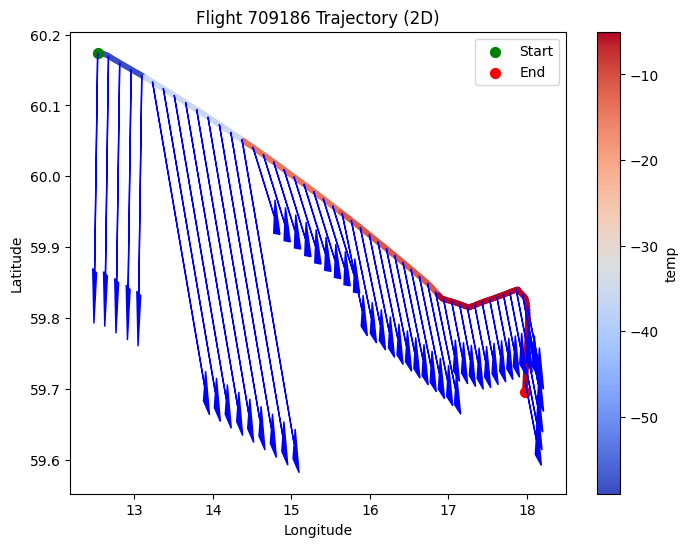

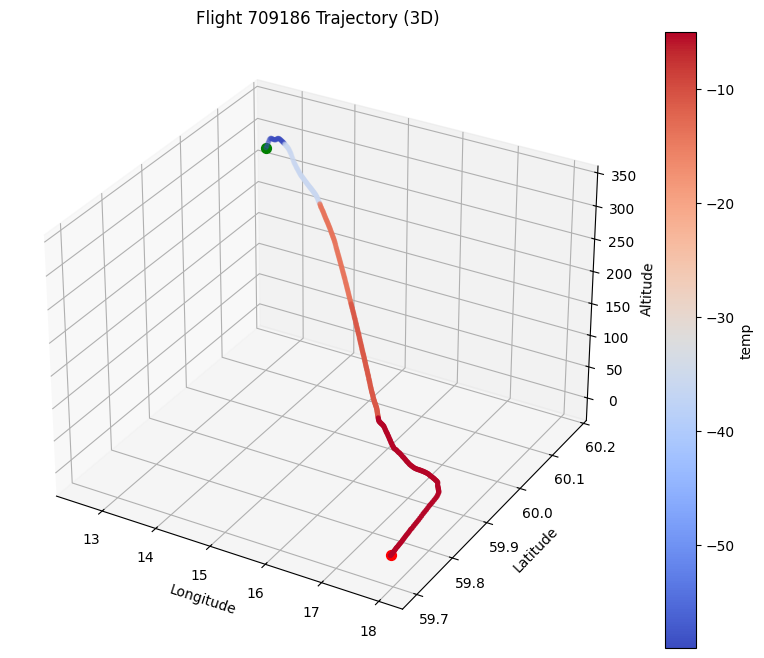

Randomly selected flight_id: 101982


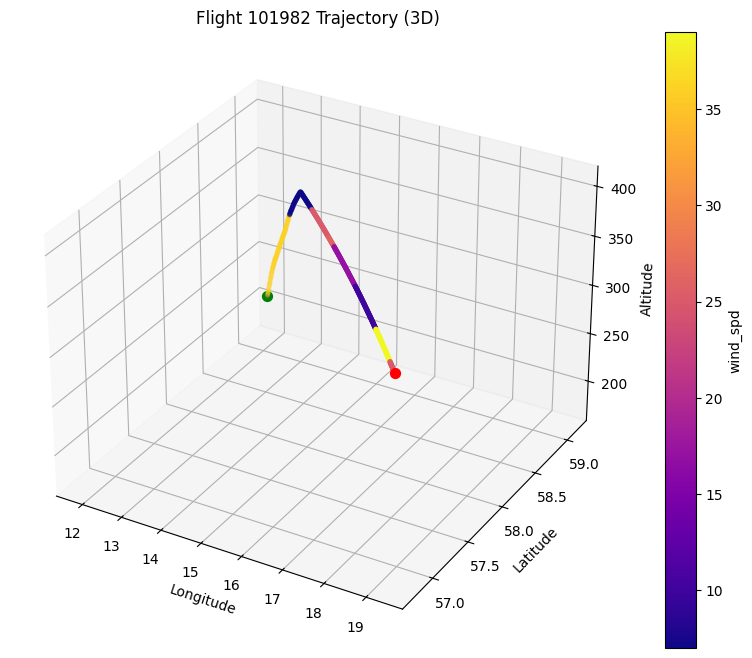

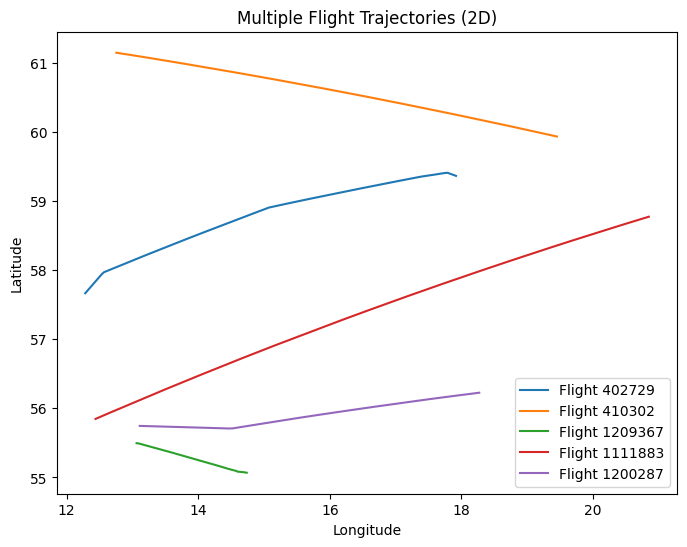

In [6]:
# EX1: single flight (2D + 3D), colored by temp w/ wind arrows
plot_flight(
    parquet_path=parquet_path,
    flight_id=None,      # random flight
    mode="2D",
    both=True,
    color_by="temp",
    show_wind=True,
    save=False
)

# EX2: single flight (3D), colored by wind speed
plot_flight(
    parquet_path=parquet_path,
    flight_id=None,
    mode="3D",
    color_by="wind_spd",
    show_wind=False
)

# EX3: multiple flights (2D)
plot_multiple_flights(
    parquet_path=parquet_path,
    count=5
)

In [7]:
# feature engineering
def compute_velocity_and_bearing_fast(df):
    lat = np.radians(df['lat'].values)
    lon = np.radians(df['lon'].values)

    dlat = np.diff(lat)
    dlon = np.diff(lon)
    R = 6371000  # Earth radius (m)

    a = np.sin(dlat/2)**2 + np.cos(lat[:-1]) * np.cos(lat[1:]) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances = R * c
    velocities = np.insert(distances, 0, 0.0)

    y = np.sin(dlon) * np.cos(lat[1:])
    x = np.cos(lat[:-1]) * np.sin(lat[1:]) - np.sin(lat[:-1]) * np.cos(lat[1:]) * np.cos(dlon)
    bearings = (np.degrees(np.arctan2(y, x)) + 360) % 360
    bearings = np.insert(bearings, 0, 0.0)

    df['velocity'] = velocities
    df['bearing'] = bearings
    return df

# apply to train/val sets
train_df = compute_velocity_and_bearing_fast(train_df)
val_df = compute_velocity_and_bearing_fast(val_df)

# keep relevant columns
feature_cols = ['lat', 'lon', 'alt', 'velocity', 'bearing']
train_df = train_df[feature_cols].dropna().reset_index(drop=True)
val_df = val_df[feature_cols].dropna().reset_index(drop=True)

# normalize
min_vals = train_df.min()
max_vals = train_df.max()
range_vals = max_vals - min_vals
range_vals[range_vals == 0] = 1  # prevent divide-by-zero

def normalize(df):
    return (df - min_vals) / range_vals

train_df = normalize(train_df)
val_df = normalize(val_df)

# denormalize predictions (for later use)
def denormalize(arr):
    return arr * range_vals.values + min_vals.values

In [10]:
# hyperparameters
SEQ_LEN = 20       # of past timesteps used for pred
PRED_LEN = 5       # of future timesteps to predict
BATCH_SIZE = 128
STRIDE = 1
MAX_SAMPLES = 200_000  # for faster training

In [13]:
# dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, stride=1, max_samples=None):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data = df.values
        self.samples = []

        for i in range(0, len(self.data) - seq_len - pred_len, stride):
            self.samples.append((i, i + seq_len, i + seq_len + pred_len))
            if max_samples and len(self.samples) >= max_samples:
                break

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s, m, e = self.samples[idx]
        past = torch.tensor(self.data[s:m], dtype=torch.float32)
        future = torch.tensor(self.data[m:e], dtype=torch.float32)
        return past, future

# create datasets
train_dataset = TrajectoryDataset(train_df, SEQ_LEN, PRED_LEN, stride=STRIDE, max_samples=MAX_SAMPLES)
val_dataset = TrajectoryDataset(val_df, SEQ_LEN, PRED_LEN, stride=STRIDE, max_samples=100_000)

# loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# debug sample
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
sample_past, sample_future = train_dataset[0]
print("Sample shapes:", sample_past.shape, sample_future.shape)


Train samples: 200000, Val samples: 100000
Sample shapes: torch.Size([20, 5]) torch.Size([5, 5])


In [38]:
class GRUForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pred_len):
        super(GRUForecastModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.pred_len = pred_len

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        outputs = []
        _, h = self.gru(x)  # get last hidden state

        # Use last input as the seed for decoding
        last_input = x[:, -1:, :]  # shape: [batch_size, 1, input_size]

        for _ in range(self.pred_len):
            out, h = self.gru(last_input, h)              # out: [batch, 1, hidden]
            pred = self.fc(out[:, -1, :])                 # pred: [batch, output_size]
            outputs.append(pred.unsqueeze(1))             # shape: [batch, 1, output_size]
            last_input = pred.unsqueeze(1)                # feed back prediction

        return torch.cat(outputs, dim=1)  # shape: [batch_size, pred_len, output_size]

In [44]:
# initialize model + training components
INPUT_SIZE = 5           # of input features
OUTPUT_SIZE = 5          # of output features (to predict)
HIDDEN_SIZE = 128         # of GRU hidden units
NUM_LAYERS = 2           # of GRU layers
LR = 0.001               # learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUForecastModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, PRED_LEN).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [45]:
# training loop
EPOCHS = 20 

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for past, future in train_loader:
        past, future = past.to(device), future.to(device)
        optimizer.zero_grad()
        preds = model(past)
        loss = criterion(preds, future)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for past, future in val_loader:
            past, future = past.to(device), future.to(device)
            preds = model(past)
            loss = criterion(preds, future)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/20 - Train Loss: 0.0027 | Val Loss: 0.0015
Epoch 2/20 - Train Loss: 0.0015 | Val Loss: 0.0014
Epoch 3/20 - Train Loss: 0.0015 | Val Loss: 0.0015
Epoch 4/20 - Train Loss: 0.0015 | Val Loss: 0.0014
Epoch 5/20 - Train Loss: 0.0015 | Val Loss: 0.0015
Epoch 6/20 - Train Loss: 0.0014 | Val Loss: 0.0015
Epoch 7/20 - Train Loss: 0.0014 | Val Loss: 0.0014
Epoch 8/20 - Train Loss: 0.0014 | Val Loss: 0.0014
Epoch 9/20 - Train Loss: 0.0014 | Val Loss: 0.0013
Epoch 10/20 - Train Loss: 0.0014 | Val Loss: 0.0014
Epoch 11/20 - Train Loss: 0.0014 | Val Loss: 0.0014
Epoch 12/20 - Train Loss: 0.0013 | Val Loss: 0.0014
Epoch 13/20 - Train Loss: 0.0013 | Val Loss: 0.0014
Epoch 14/20 - Train Loss: 0.0013 | Val Loss: 0.0013
Epoch 15/20 - Train Loss: 0.0013 | Val Loss: 0.0013
Epoch 16/20 - Train Loss: 0.0013 | Val Loss: 0.0014
Epoch 17/20 - Train Loss: 0.0013 | Val Loss: 0.0013
Epoch 18/20 - Train Loss: 0.0013 | Val Loss: 0.0013
Epoch 19/20 - Train Loss: 0.0013 | Val Loss: 0.0013
Epoch 20/20 - Train L

In [46]:
# get a batch from validation loader
sample_batch = next(iter(val_loader))
past, future = sample_batch
past, future = past.to(device), future.to(device)

# forward pass
with torch.no_grad():
    preds = model(past)  # [batch_size, PRED_LEN, 5]

# move to CPU + denormalize
true_future = denormalize(future.cpu().numpy())     # [batch_size, PRED_LEN, 5]
predicted   = denormalize(preds.cpu().numpy())      # [batch_size, PRED_LEN, 5]

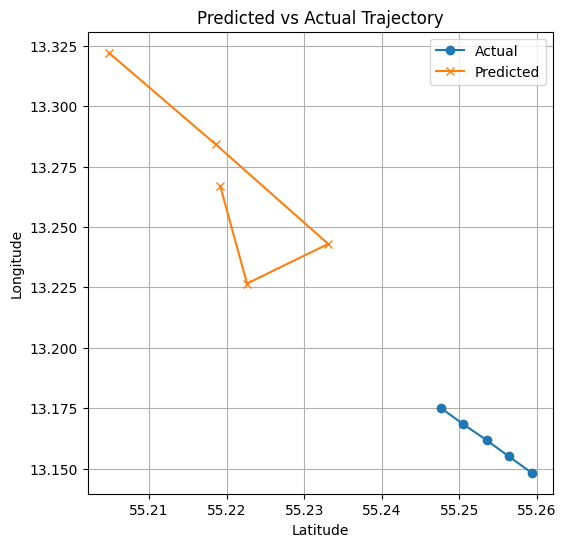

In [47]:
# plot lat vs lon for first sample in batch
plt.figure(figsize=(6, 6))
plt.plot(true_future[0][:, 0], true_future[0][:, 1], label="Actual", marker='o')       # lat vs lon
plt.plot(predicted[0][:, 0], predicted[0][:, 1], label="Predicted", marker='x')        # lat vs lon
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted vs Actual Trajectory")
plt.grid(True)
plt.legend()
plt.show()